In [ ]:
!pip install torchdiffeq
!pip install torchdyn

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.set_default_dtype(torch.float32)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time

from torchdiffeq import odeint, odeint_adjoint

from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *
import torch.utils.data as data
import torch.nn as nn
import pytorch_lightning as pl

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(str(device) + ' is being used...')

import scipy.io
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0 is being used...


In [22]:
filePath = '/content/000075.txt'
with open(filePath) as f:
    lines = f.readlines()

rho = []
NandC = []
vals = []

try:
    for line in lines:
        line = line.strip('\n')

        checkingTargetValues = list(np.array(line.split(', '), dtype = np.float32))
        boolFlag = True
        for i in checkingTargetValues:
            if np.isinf(i) or np.isnan(i):
                boolFlag = False

        if boolFlag:
            vals.append(list(np.array(line.split(', '), dtype = np.float32)))

except ValueError:
    pass

if boolFlag:
    if len(vals[0]) == 2000:
        rho.append(vals[0])
        NandC.append(vals[1:])

u = torch.tensor(rho)
y = torch.tensor(NandC)
u, y = u[-1].reshape(-1, 1).to(device), y[-1].to(device)
y = y.transpose(0, 1)

Tsim, dt = 100, 50e-03
data_size = Tsim / dt
t = torch.linspace(0., Tsim, int(data_size)).to(device)

print(t.shape, u.shape, y.shape)

torch.Size([2000]) torch.Size([2000, 1]) torch.Size([2000, 7])


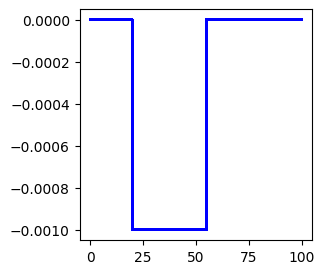

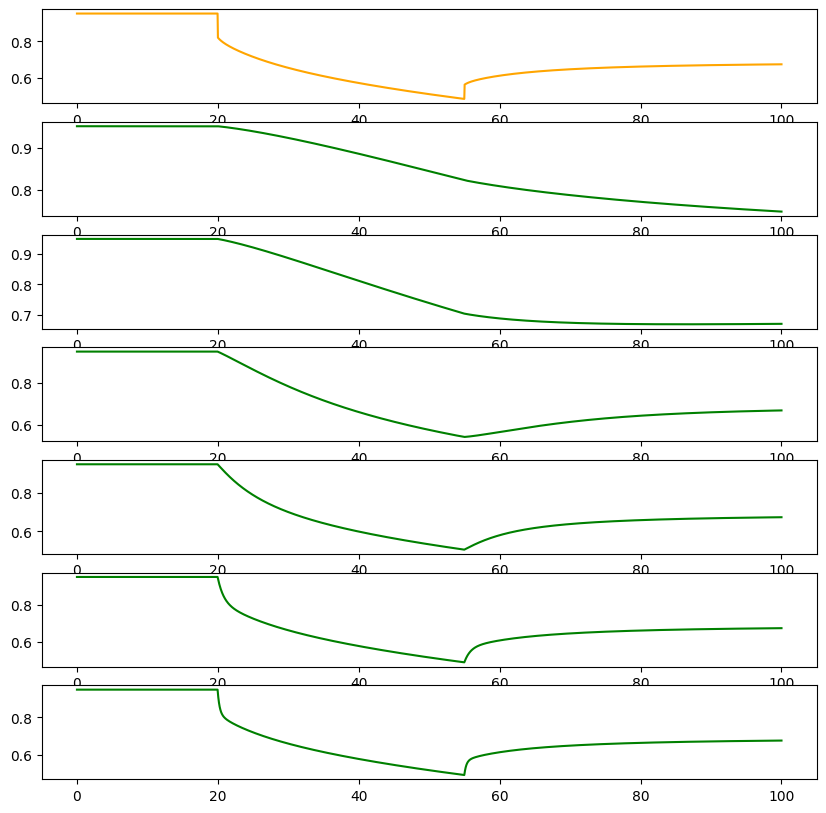

In [23]:
# ***** Visualing *****
def visualize(t, u, true_y, pred_y=None):
  fig1 = plt.figure(figsize = (3, 3))
  axs1 = fig1.subplots(1, 1)

  for i in range(0, len(u)):
    axs1.plot(t.cpu().numpy(), u.cpu().detach().numpy(), 'blue', label='u')

  fig2 = plt.figure(figsize = (10, 10))
  axs = fig2.subplots(7, 1)

  for i in range(0, true_y.shape[1]):
    if i == 0:
        color = 'orange'
    else:
        color = 'green'
    axs[i].plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, i], color, label='y')

  plt.show()

visualize(t, u, y)

In [24]:
# ***** Visualing *****
def visualizePred(true_y, pred_y=None):
  fig1 = plt.figure(figsize = (3, 3))
  axs1 = fig1.subplots(1, 1)

  for i in range(0, len(u)):
    axs1.plot(t.cpu().numpy(), u.cpu().detach().numpy(), 'blue', label='u')

  fig2 = plt.figure(figsize = (10, 10))
  axs = fig2.subplots(7, 1)

  for i in range(0, true_y.shape[1]):
    if i == 0:
        color = 'orange'
    else:
        color = 'green'
    axs[i].plot(t.cpu().numpy(), true_y.cpu().detach().numpy()[:, i], color, label='y')

    if pred_y is not None:
        axs[i].plot(t.cpu().numpy(), pred_y.cpu().detach().numpy()[:, i], 'red', label='prediction')

  plt.show()

In [25]:
train = data.TensorDataset(u, y)
trainloader = data.DataLoader(train, batch_size=y.shape[0], shuffle=True)

In [38]:
class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        print(x.shape, y.shape)
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        y_hat = y_hat[:, -7:]   # Slicing from the 5th element upto the last
        loss = torch.mean(torch.abs(y_hat - y))
        print('loss: ', loss)
        # plt.clf()
        # visualizePred(y, y_hat)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [43]:
# Vector Field parametrized by a NN which takes as input [h, x]
vector_field = nn.Sequential(DataControl(),
                             nn.Linear(9, 64),
                             nn.Tanh(),
                             nn.Linear(64, 9))

# Neural ODE
model = NeuralODE(vector_field, sensitivity='interpolated_adjoint', solver='tsit5', atol=1e-3, rtol=1e-3).to(device)

tspan = torch.linspace(0., 1, 100).to(device)
print(tspan.shape)
learn = Learner(tspan, model)
trainer = pl.Trainer(min_epochs=150, max_epochs=200)
trainer.fit(learn)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 1.2 K 
------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
torch.Size([100])


Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([2000, 1]) torch.Size([2000, 7])
torch.Size([2000, 1])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size([2000, 9])
torch.Size

RuntimeError: ignored

In [ ]:
y_hat = model.to(device)(u, t)[1][-7, :,:][:,-7:]
visualizePred(y, y_hat)